Reference: https://keras.io/examples/generative/ddim/

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import layers
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.optimizers import Adam
from keras.losses import mean_absolute_error
import cv2

In [2]:
# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

optimizer = Adam(0.0002, 0.5)

In [3]:
batch_size = 8
image_size = 256
channels = 1

def preprocessing_function(image):
    image = image.astype(float) / 255
    return image

idg = ImageDataGenerator(preprocessing_function = preprocessing_function)
heightmap_iterator = idg.flow_from_directory('../../heightmaps/uncorrupted_split_heightmaps_second_pass', 
                                             target_size = (image_size, image_size), 
                                             batch_size = batch_size,
                                             color_mode = 'grayscale',
                                             classes = [''])

Found 582569 images belonging to 1 classes.


In [4]:
def show_images(images, rows, columns):
    i = 0
    f, axs = plt.subplots(rows, columns, figsize=(100,35))
    for x in axs.flatten():
        x.imshow(images[i], cmap='gray')
        x.axis('off')
        i += 1
    plt.tight_layout()
    plt.show()

In [5]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    #angular_speeds = tf.cast(angular_speeds, tf.float16)
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

In [6]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

In [7]:
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

In [8]:
def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [9]:
def create_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, channels))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(channels, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

In [10]:
def diffusion_schedule(diffusion_times):
    # diffusion times -> angles
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    # angles -> signal and noise rates
    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [11]:
def reverse_diffusion(model, num_images, diffusion_steps):
    initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, channels))
    step_size = 1.0 / diffusion_steps
    
    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images
        
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        
        #pred_noises = model.predict([noisy_images, noise_rates**2])
        pred_noises = model([noisy_images, noise_rates**2], training = True)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        
    return pred_images

In [12]:
def train(directory_iterator, model, epochs):
    directory_iterator.reset()
    steps_per_epoch = directory_iterator.__len__() - 1
    
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            images = np.asarray(directory_iterator.next()[0])
            if images.shape[0] != batch_size:
                continue
                
            noises = tf.random.normal(shape=(batch_size, image_size, image_size, channels))

            diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
            noise_rates, signal_rates = diffusion_schedule(diffusion_times)

            noisy_images = signal_rates * images + noise_rates * noises
            model.train_on_batch([noisy_images, noise_rates**2], noises)
            
        print('Epoch ' + str(57 + epoch + 1) + ' completed.')
        model.save('../data/models/diffusion_models/diffusion1_epoch' + str(57 + epoch + 1))
        generated_images = reverse_diffusion(network, num_images = 7, diffusion_steps = 20)
        show_images(generated_images, rows = 1, columns = 7)
    
    return model

## Mixed Precision Experiment

In [18]:
from datetime import datetime

In [19]:
epoch_start_time = datetime.now()

In [20]:
epoch_end_time = datetime.now()
epoch_delta_time = epoch_end_time - epoch_start_time

In [27]:
print('Epoch ' + str(4) + ' completed at ' + str(epoch_end_time.hour) + ':' + str(epoch_end_time.minute) + ' in ' + str(epoch_delta_time))

Epoch 4 completed at 17:57 in 0:00:39.894501


In [13]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


In [20]:
new_model = create_network(image_size, widths, block_depth)
new_model.compile(optimizer = optimizer, loss = mean_absolute_error)

In [15]:
for i in range(10):
    print(new_model.get_layer(index=i).dtype_policy)

<Policy "float32">
<Policy "float32">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">


In [60]:
old_model = keras.models.load_model('data/saved_models/epoch/diffusion_models/diffusion1_epoch_33')

In [61]:
weights = old_model.get_weights()
for weight in weights:
    weight = tf.cast(weight, tf.float16)
#weights_float16 = [weight = tf.cast(weight, tf.float16) for weight in weights]
new_model.set_weights(weights)

In [14]:
def short_train(directory_iterator, model, epochs):
    directory_iterator.reset()
    steps_per_epoch = 1600
    
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            images = np.asarray(directory_iterator.next()[0])
            if images.shape[0] != batch_size:
                continue
                
            noises = tf.random.normal(shape=(batch_size, image_size, image_size, channels))

            diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
            noise_rates, signal_rates = diffusion_schedule(diffusion_times)

            noisy_images = signal_rates * images + noise_rates * noises
            model.train_on_batch([noisy_images, noise_rates**2], noises)
    
    return model

### policy = mixed_float16, batch_size = 8

In [17]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

float16_test_model = create_network(image_size, widths, block_depth)
float16_test_model.compile(optimizer = optimizer, loss = mean_absolute_error)

for i in range(10):
    print(float16_test_model.get_layer(index=i).dtype_policy)

time_before = datetime.datetime.now()
float16_test_model = short_train(heightmap_iterator, float16_test_model, 1)
time_after = datetime.datetime.now()
print('Time to train:', time_after - time_before)

<Policy "float32">
<Policy "float32">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
Time to train: 0:03:51.724892


### policy = float32, batch_size = 8

In [20]:
tf.keras.mixed_precision.set_global_policy('float32')

float32_test_model = create_network(image_size, widths, block_depth)
float32_test_model.compile(optimizer = optimizer, loss = mean_absolute_error)

for i in range(10):
    print(float32_test_model.get_layer(index=i).dtype_policy)
    
time_before = datetime.datetime.now()
float16_test_model = short_train(heightmap_iterator, float32_test_model, 1)
time_after = datetime.datetime.now()
print('Time to train:', time_after - time_before)

<Policy "float32">
<Policy "float32">
<Policy "float32">
<Policy "float32">
<Policy "float32">
<Policy "float32">
<Policy "float32">
<Policy "float32">
<Policy "float32">
<Policy "float32">
Time to train: 0:04:39.990107


### policy = mixed_float16, batch_size = 16

In [15]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

float16_test_model_2 = create_network(image_size, widths, block_depth)
float16_test_model_2.compile(optimizer = optimizer, loss = mean_absolute_error)

for i in range(10):
    print(float16_test_model_2.get_layer(index=i).dtype_policy)

time_before = datetime.datetime.now()
float16_test_model_2 = short_train(heightmap_iterator, float16_test_model_2, 1)
time_after = datetime.datetime.now()
print('Time to train:', time_after - time_before)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6
<Policy "float32">
<Policy "float32">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
Time to train: 0:06:42.727248


Note: might be worth it to switch to a mixed precision policy for faster training, but the feasability of switching float32 models to mixed_float16 models, as well as the model quality after training with mixed precision needs to be assessed.

### End of mixed precision experiment

In [15]:
#network = create_network(image_size, widths, block_depth)
#network.compile(optimizer = optimizer, loss = mean_absolute_error)

In [13]:
network = keras.models.load_model('../data/models/diffusion_models/diffusion1_epoch57')

In [ ]:
network = train(heightmap_iterator, network, 10)

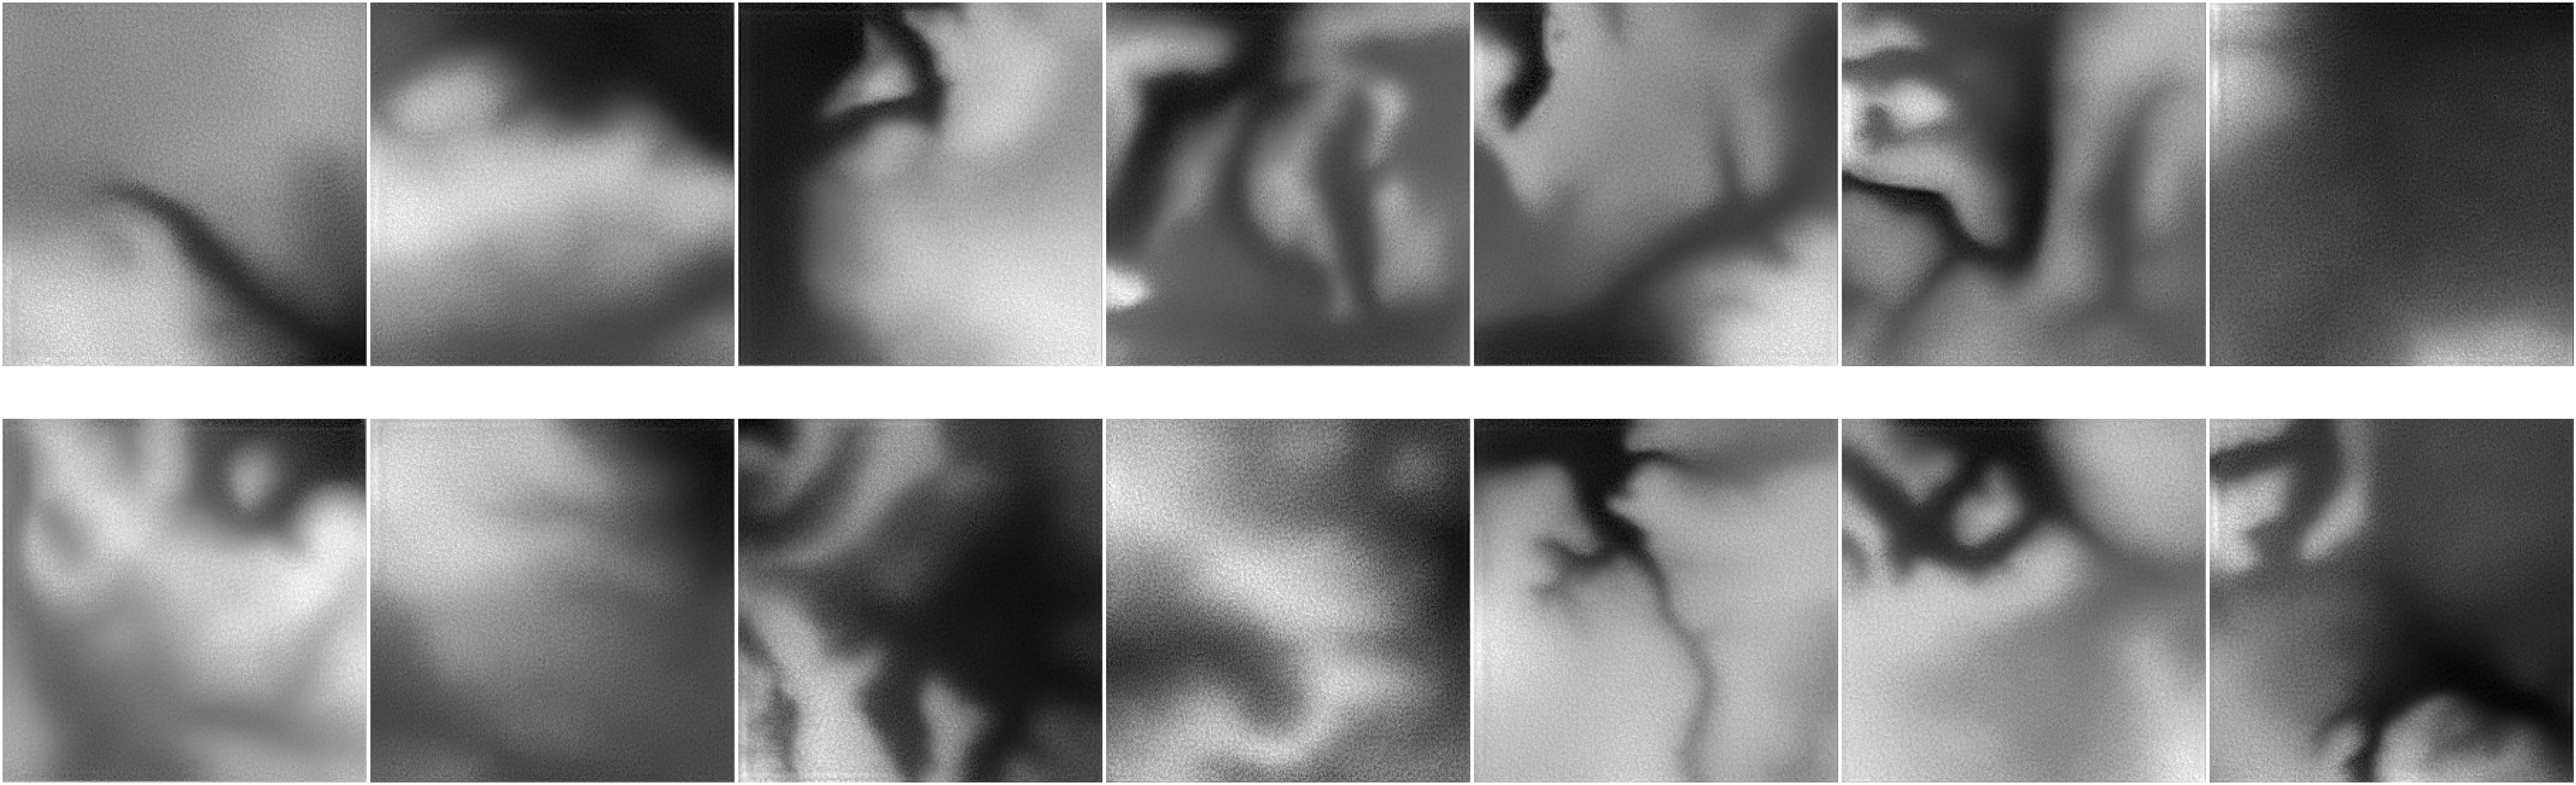

In [17]:
generated_images = reverse_diffusion(network, num_images = 14, diffusion_steps = 20)
show_images(generated_images, rows = 2, columns = 7)

# Diffusion Blending

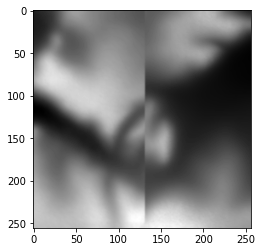

In [21]:
test_image = cv2.imread('data/diffusion_blend_test_image.png', 0)
plt.imshow(test_image, cmap='gray')

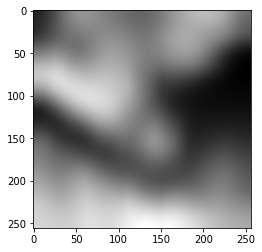

In [22]:
blurred_image = cv2.blur(test_image, (40, 40))
test_image = np.asarray(blurred_image)
test_image = test_image.reshape((1, image_size, image_size, channels))
plt.imshow(test_image[0], cmap='gray')

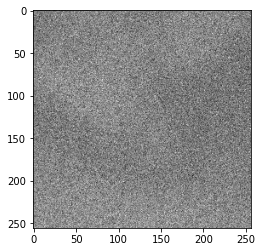

In [31]:
test_noise = tf.random.normal(shape=(1, image_size, image_size, channels))
signal_rate = 0.005
noise_rate = 1
noisy_image = signal_rate * test_image + noise_rate * test_noise
plt.imshow(noisy_image[0], cmap='gray')

In [32]:
def image_to_image(model, images, num_images, diffusion_steps, starting_step):
    step_size = 1.0 / diffusion_steps
    
    next_noisy_images = images
    for step in range(diffusion_steps - starting_step):
        noisy_images = next_noisy_images
        
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - (step + starting_step) * step_size
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        
        pred_noises = model([noisy_images, noise_rates**2], training = True)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
    
    return pred_images

In [33]:
blended_image = image_to_image(network, images = noisy_image, num_images = 1, diffusion_steps = 20, starting_step = 0)

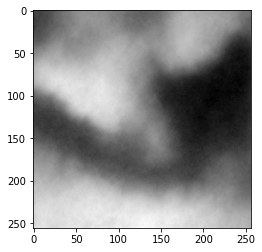

In [34]:
plt.imshow(blended_image[0], cmap='gray')